In [1]:
import pandas as pd
from matplotlib import colors
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import numpy as np

# 定义文件路径
file_path = 'vdjdb.txt'  # 将 'your_file.txt' 替换为你的文件路径

# 读取文件内容
with open(file_path, 'r', encoding='utf-8') as file:
    # 读取文件的第一行，获取所有的信息变量名
    header = file.readline().strip().split('\t')
    tcr_data = [dict(zip(header, line.strip().split('\t'))) for line in file]
cdr3_dict = {}
for row in tcr_data:
    complex_id = row['complex.id']
    cdr3 = row['cdr3']
    # Splice together CDR3 with the same complex ID
    if complex_id in cdr3_dict:
        cdr3_dict[complex_id].append(cdr3)
    else:
        cdr3_dict[complex_id] = [cdr3]
# There is a DataFrame containing the TCR sequence
for row in tcr_data:
    complex_id = row['complex.id']
    antigen_epitope = row['antigen.epitope']
    vdjdb_score = row['vdjdb.score']
    # Splice together CDR3 with the same complex ID
    if len(cdr3_dict[complex_id]) == 2:
        cdr3_dict[complex_id].append(antigen_epitope)
        cdr3_dict[complex_id].append(vdjdb_score)
    else:
        continue
cdr3_dict.pop('0')
##Delete unpaired TCRs
df_cdr3 = pd.DataFrame(cdr3_dict)
df_cdr3_trans = df_cdr3.transpose()
names = ['TRA', 'TRB', 'antigen_epitope', 'vdjdb.score']
df_cdr3_trans.columns = names
print(df_cdr3_trans)
##The first step is to read out the paired data

                  TRA                   TRB antigen_epitope vdjdb.score
1       CIVRAPGRADMRF  CASSYLPGQGDHYSNQPQHF        FLKEKGGL           2
2      CAVPSGAGSYQLTF   CASSFEPGQGFYSNQPQHF        FLKEKGGL           2
3         CAVKASGSRLT  CASSYEPGQVSHYSNQPQHF        FLKEKGGL           2
4       CAYRPPGTYKYIF        CASSALASLNEQFF        FLKEKGGL           2
5       CIVRAPGRADMRF  CASSYLPGQGDHYSNQPQHF        FLKEQGGL           2
...               ...                   ...             ...         ...
30590   CMDEGGSNYKLTF         CASSVRSTDTQYF    PQPELPYPQPQL           0
30591     CSLYNNNDMRF         CASSLRYTDTQYF    PQPELPYPQPQL           0
30592   CALSTDSWGKLQF       CASSPGQGGDNEQFF   PQQPFPQPEQPFP           0
30593    CAPQGATNKLIF       CASSLGAGGQETQYF   PQQPFPQPEQPFP           2
30594  CLVGGSGGYNKLIF         CASSSTAQETQYF   PQQPFPQPEQPFP           0

[30594 rows x 4 columns]


In [3]:
df_clean = df_cdr3_trans[df_cdr3_trans['vdjdb.score'] != '0']
#df_clean = df_clean.drop_duplicates()
df_clean = df_clean.reset_index(drop=True)
df_clean['TRA_TRB_Combined'] = df_clean["TRA"] + df_clean["TRB"]
specific_antigen_epitopes = ['PQPELPYPQPQL', 'FLKETGGL','YVLDHLIVV']
df_clean = df_clean[df_clean['antigen_epitope'].isin(specific_antigen_epitopes)]
df_clean = df_clean.reset_index(drop=True)
print("There are {} categories of data in the current dataset".format(np.shape(df_clean['antigen_epitope'].unique())))
print(df_clean)

There are (3,) categories of data in the current dataset
              TRA                   TRB antigen_epitope vdjdb.score  \
0   CIVRAPGRADMRF  CASSYLPGQGDHYSNQPQHF        FLKETGGL           2   
1  CAVPSGAGSYQLTF   CASSFEPGQGFYSNQPQHF        FLKETGGL           2   
2     CAVKASGSRLT  CASSYEPGQVSHYSNQPQHF        FLKETGGL           2   
3     CAYRSAFKLTF       CAWSVPLGRREKLFF       YVLDHLIVV           3   
4  CLVGGDNQGGKLIF        CASSQRQGGNTIYF    PQPELPYPQPQL           2   
5     CIVYNNNDMRF         CASSIRSTDTQYF    PQPELPYPQPQL           2   
6     CIVFNDYKLSF         CASSFRSTDTQYF    PQPELPYPQPQL           2   
7      CIALNARLMF         CASSLRATDTQYF    PQPELPYPQPQL           2   

                    TRA_TRB_Combined  
0  CIVRAPGRADMRFCASSYLPGQGDHYSNQPQHF  
1  CAVPSGAGSYQLTFCASSFEPGQGFYSNQPQHF  
2    CAVKASGSRLTCASSYEPGQVSHYSNQPQHF  
3         CAYRSAFKLTFCAWSVPLGRREKLFF  
4       CLVGGDNQGGKLIFCASSQRQGGNTIYF  
5           CIVYNNNDMRFCASSIRSTDTQYF  
6           CIVFNDYKLSFCASSFRS

In [4]:
##Edit Distance
def ED(str_1, str_2):
    m = len(str_1)
    n = len(str_2)
    # Initializes the dynamic programming matrix with sizes m+1 and n+1 respectively
    Distance = [[0 for _ in range(n + 1)] for _ in range(m + 1)]
    for i in range(n + 1):
        Distance[0][i] = i
    #
    for j in range(m + 1):
        Distance[j][0] = j
    # Initialize the first row and column of the matrix
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            distance_delete = Distance[i - 1][j] + 1
            distance_add = Distance[i][j - 1] + 1
            if str_1[i - 1] == str_2[j - 1]:
                distance_change = Distance[i - 1][j - 1]
            else:
                distance_change = Distance[i - 1][j - 1] + 1
            Distance[i][j] = min(distance_delete, distance_add, distance_change)
    # Count the items from bottom to top
    return Distance[m][n]

In [5]:
##Jaccard Distance
def jaccard_distance(str1, str2):
    set1 = set(str1)
    set2 = set(str2)
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return 1 - intersection / union

In [7]:
Distance_Matrix_TRA = np.zeros((df_clean.shape[0], df_clean.shape[0]))
Distance_Matrix_TRB = np.zeros((df_clean.shape[0], df_clean.shape[0]))
Distance_Matrix_TRAandTRB = np.zeros((df_clean.shape[0], df_clean.shape[0]))
for i in range(df_clean.shape[0]):
    for j in range(df_clean.shape[0]):
        Distance_Matrix_TRA[i][j] = jaccard_distance(df_clean['TRA'][i], df_clean['TRA'][j])
        Distance_Matrix_TRB[i][j] = jaccard_distance(df_clean['TRB'][i], df_clean['TRB'][j])
        Distance_Matrix_TRAandTRB[i][j] = jaccard_distance(df_clean['TRA_TRB_Combined'][i], df_clean['TRA_TRB_Combined'][j])
    if i % 10 == 0:
        print("Currently, {: 2f} TCR3s have been calculated".format(j))

Currently,  7.000000 TCR3s have been calculated


In [8]:
from sklearn.decomposition import PCA

# #Initialize PCA object and specify the dimension to be lowered to
pca = PCA(n_components=2)

#Perform PCA dimensionality reduction on the original matrix
transformed_matrix_TRA = pca.fit_transform(Distance_Matrix_TRA)
transformed_matrix_TRB = pca.fit_transform(Distance_Matrix_TRB)
transformed_matrix_TRAandTRB = pca.fit_transform(Distance_Matrix_TRAandTRB)

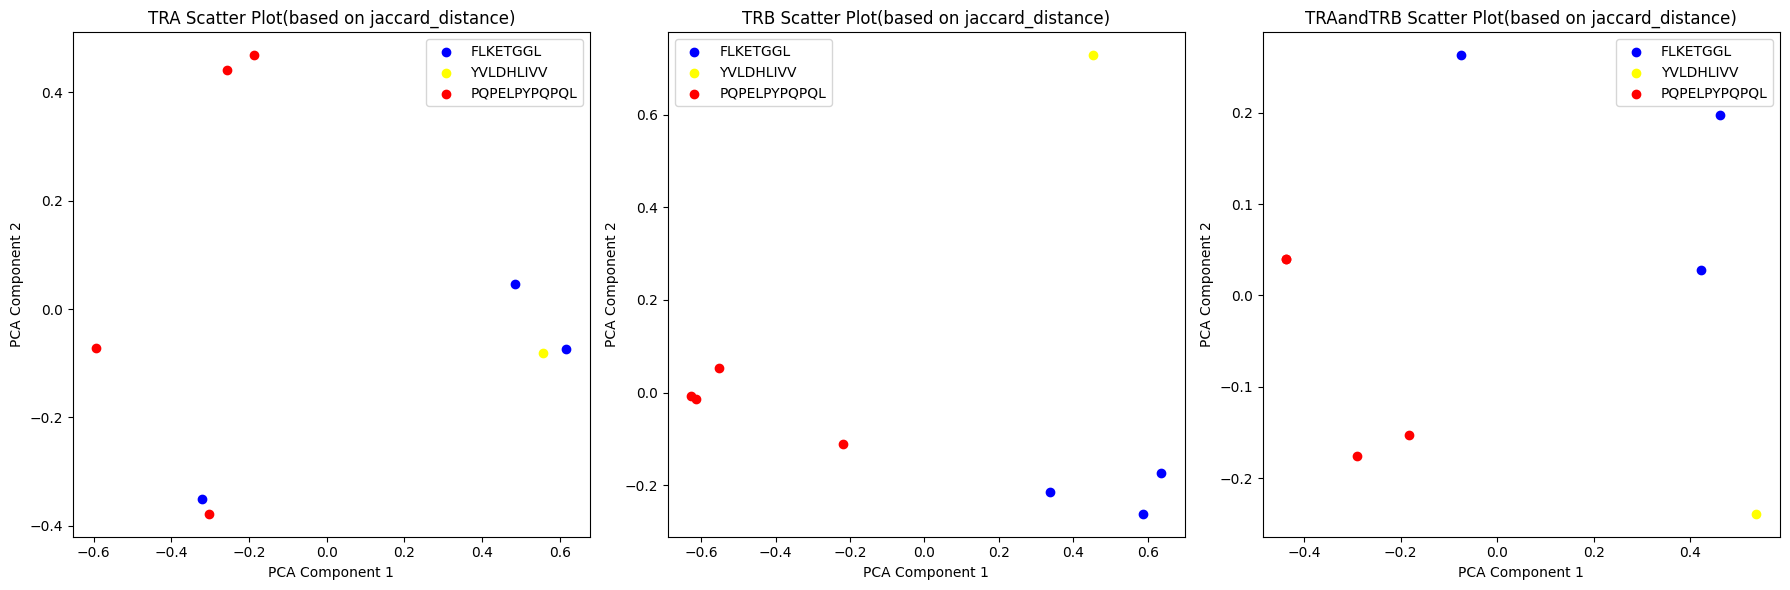

In [10]:
plt.figure(figsize=(18, 6))  # 调整图形大小
# 绘制第一个子图，TRA
plt.subplot(1, 3, 1)
x_values = transformed_matrix_TRA[:, 0]
y_values = transformed_matrix_TRA[:, 1]
antigen_epitope_values = df_clean['antigen_epitope'].unique()
color_dict={'PQPELPYPQPQL':'red','FLKETGGL':'blue','YVLDHLIVV':'yellow'}


added_labels=set()
# 绘制散点图
for i in range(df_clean.shape[0]):
    antigen_epitope = df_clean['antigen_epitope'][i]
    if antigen_epitope not in added_labels:
        plt.scatter(x_values[i], y_values[i], color=color_dict[antigen_epitope], label=antigen_epitope)
        added_labels.add(antigen_epitope)
    else:
        plt.scatter(x_values[i], y_values[i], color=color_dict[antigen_epitope])
# 添加图例和标签
plt.legend()
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('TRA Scatter Plot(based on jaccard_distance)')
# 绘制第二个子图，TRB
plt.subplot(1, 3, 2)
x_values = transformed_matrix_TRB[:, 0]
y_values = transformed_matrix_TRB[:, 1]
antigen_epitope_values = df_clean['antigen_epitope'].unique()



added_labels=set()
# 绘制散点图
for i in range(df_clean.shape[0]):
    antigen_epitope = df_clean['antigen_epitope'][i]
    if antigen_epitope not in added_labels:
        plt.scatter(x_values[i], y_values[i], color=color_dict[antigen_epitope], label=antigen_epitope)
        added_labels.add(antigen_epitope)
    else:
        plt.scatter(x_values[i], y_values[i], color=color_dict[antigen_epitope])
# 添加图例和标签
plt.legend()
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('TRB Scatter Plot(based on jaccard_distance)')
# 绘制第三个子图，TRATRB——combined
plt.subplot(1, 3, 3)
x_values = transformed_matrix_TRAandTRB[:, 0]
y_values = transformed_matrix_TRAandTRB[:, 1]
antigen_epitope_values = df_clean['antigen_epitope'].unique()
added_labels=set()
# 绘制散点图
for i in range(df_clean.shape[0]):
    antigen_epitope = df_clean['antigen_epitope'][i]
    if antigen_epitope not in added_labels:
        plt.scatter(x_values[i], y_values[i], color=color_dict[antigen_epitope], label=antigen_epitope)
        added_labels.add(antigen_epitope)
    else:
        plt.scatter(x_values[i], y_values[i], color=color_dict[antigen_epitope])
# 添加图例和标签
plt.legend()
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('TRAandTRB Scatter Plot(based on jaccard_distance)')
# 显示图形
plt.tight_layout()
plt.show()

In [11]:
##We use edit distance for visual comparison
Distance_Matrix_TRA = np.zeros((df_clean.shape[0], df_clean.shape[0]))
Distance_Matrix_TRB = np.zeros((df_clean.shape[0], df_clean.shape[0]))
Distance_Matrix_TRAandTRB = np.zeros((df_clean.shape[0], df_clean.shape[0]))
for i in range(df_clean.shape[0]):
    for j in range(df_clean.shape[0]):
        Distance_Matrix_TRA[i][j] = ED(df_clean['TRA'][i], df_clean['TRA'][j])
        Distance_Matrix_TRB[i][j] = ED(df_clean['TRB'][i], df_clean['TRB'][j])
        Distance_Matrix_TRAandTRB[i][j] = ED(df_clean['TRA_TRB_Combined'][i], df_clean['TRA_TRB_Combined'][j])
    if i % 10 == 0:
        print("Currently, {: 2f} TCR3s have been calculated".format(j))

Currently,  7.000000 TCR3s have been calculated


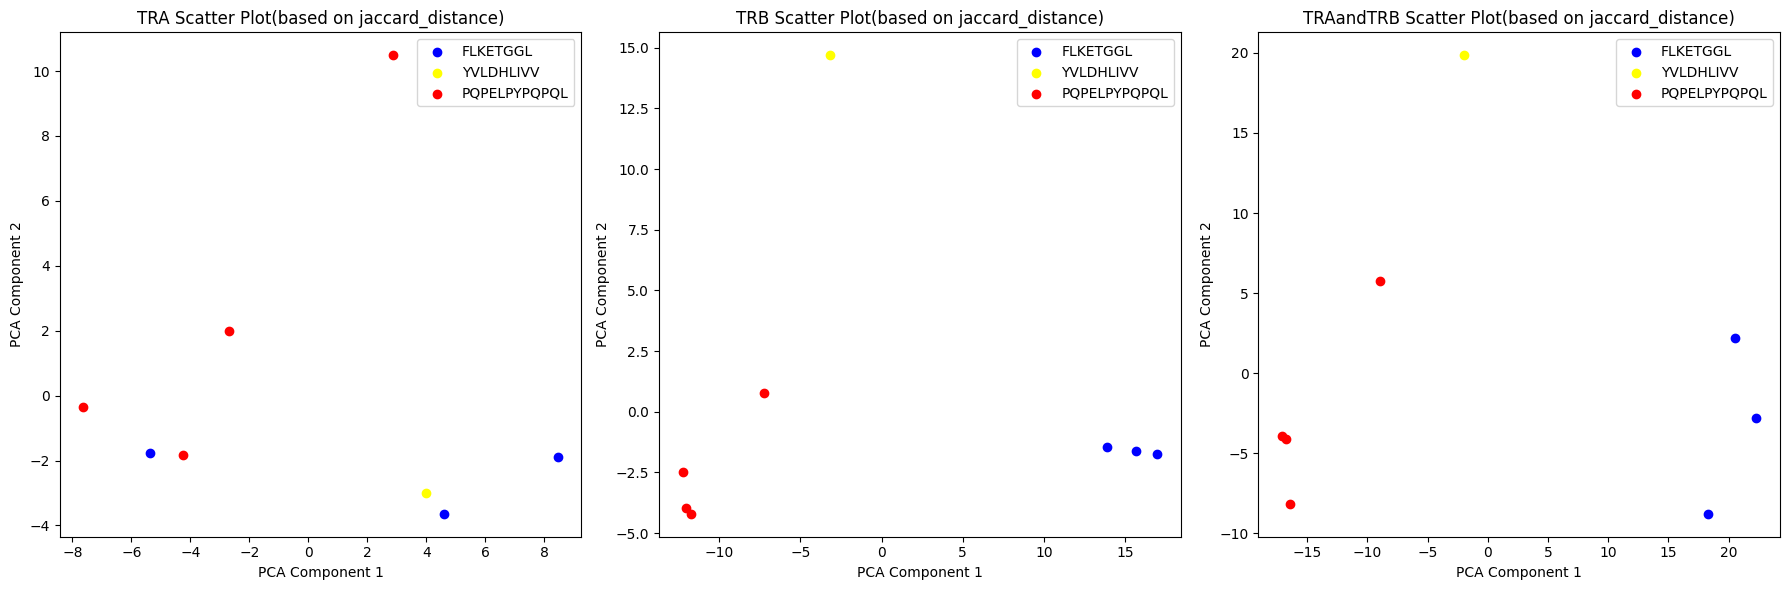

In [12]:
from sklearn.decomposition import PCA

# #Initialize PCA object and specify the dimension to be lowered to
pca = PCA(n_components=2)

#Perform PCA dimensionality reduction on the original matrix
transformed_matrix_TRA = pca.fit_transform(Distance_Matrix_TRA)
transformed_matrix_TRB = pca.fit_transform(Distance_Matrix_TRB)
transformed_matrix_TRAandTRB = pca.fit_transform(Distance_Matrix_TRAandTRB)
plt.figure(figsize=(18, 6))  # 调整图形大小
# 绘制第一个子图，TRA
plt.subplot(1, 3, 1)
x_values = transformed_matrix_TRA[:, 0]
y_values = transformed_matrix_TRA[:, 1]
antigen_epitope_values = df_clean['antigen_epitope'].unique()
color_dict={'PQPELPYPQPQL':'red','FLKETGGL':'blue','YVLDHLIVV':'yellow'}


added_labels=set()
# 绘制散点图
for i in range(df_clean.shape[0]):
    antigen_epitope = df_clean['antigen_epitope'][i]
    if antigen_epitope not in added_labels:
        plt.scatter(x_values[i], y_values[i], color=color_dict[antigen_epitope], label=antigen_epitope)
        added_labels.add(antigen_epitope)
    else:
        plt.scatter(x_values[i], y_values[i], color=color_dict[antigen_epitope])
# 添加图例和标签
plt.legend()
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('TRA Scatter Plot(based on edit distance)')
# 绘制第二个子图，TRB
plt.subplot(1, 3, 2)
x_values = transformed_matrix_TRB[:, 0]
y_values = transformed_matrix_TRB[:, 1]
antigen_epitope_values = df_clean['antigen_epitope'].unique()



added_labels=set()
# 绘制散点图
for i in range(df_clean.shape[0]):
    antigen_epitope = df_clean['antigen_epitope'][i]
    if antigen_epitope not in added_labels:
        plt.scatter(x_values[i], y_values[i], color=color_dict[antigen_epitope], label=antigen_epitope)
        added_labels.add(antigen_epitope)
    else:
        plt.scatter(x_values[i], y_values[i], color=color_dict[antigen_epitope])
# 添加图例和标签
plt.legend()
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('TRB Scatter Plot(based on edit distance)')
# 绘制第三个子图，TRATRB——combined
plt.subplot(1, 3, 3)
x_values = transformed_matrix_TRAandTRB[:, 0]
y_values = transformed_matrix_TRAandTRB[:, 1]
antigen_epitope_values = df_clean['antigen_epitope'].unique()
added_labels=set()
# 绘制散点图
for i in range(df_clean.shape[0]):
    antigen_epitope = df_clean['antigen_epitope'][i]
    if antigen_epitope not in added_labels:
        plt.scatter(x_values[i], y_values[i], color=color_dict[antigen_epitope], label=antigen_epitope)
        added_labels.add(antigen_epitope)
    else:
        plt.scatter(x_values[i], y_values[i], color=color_dict[antigen_epitope])
# 添加图例和标签
plt.legend()
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('TRAandTRB Scatter Plot(based on edit distance)')
# 显示图形
plt.tight_layout()
plt.show()